SIFT+Random forest

E:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Classification Report (Balanced):
               precision    recall  f1-score   support

 Agriculture       0.61      0.61      0.61       171
     Airport       0.50      0.49      0.49       158
       Beach       0.60      0.59      0.59       169
        City       0.61      0.72      0.66       166
      Desert       0.56      0.58      0.57       158
      Forest       0.72      0.87      0.79       143
   Grassland       0.66      0.62      0.64       167
     Highway       0.49      0.60      0.54       158
        Lake       0.38      0.19      0.25       154
    Mountain       0.65      0.75      0.69       162
     Parking       0.88      0.82      0.85       171
        Port       0.62      0.56      0.59       155
     Railway       0.66      0.72      0.69       164
 Residential       0.62      0.84      0.71       148
       River       0.40      0.21      0.27       156

    accuracy                           0.61      2400
   macro avg       0.60      0.61      0.60  

E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report (Imbalanced):
               precision    recall  f1-score   support

 Agriculture       0.20      0.74      0.32       171
     Airport       0.19      0.09      0.13       158
       Beach       0.27      0.62      0.37       169
        City       0.57      0.02      0.05       166
      Desert       0.20      0.63      0.31       158
      Forest       0.40      0.73      0.51       143
   Grassland       0.28      0.60      0.38       167
     Highway       0.76      0.08      0.15       158
        Lake       0.06      0.01      0.01       154
    Mountain       0.82      0.06      0.10       162
     Parking       0.84      0.31      0.45       171
        Port       0.55      0.28      0.37       155
     Railway       0.00      0.00      0.00       164
 Residential       0.00      0.00      0.00       148
       River       0.50      0.03      0.05       156

    accuracy                           0.28      2400
   macro avg       0.38      0.28      0.21

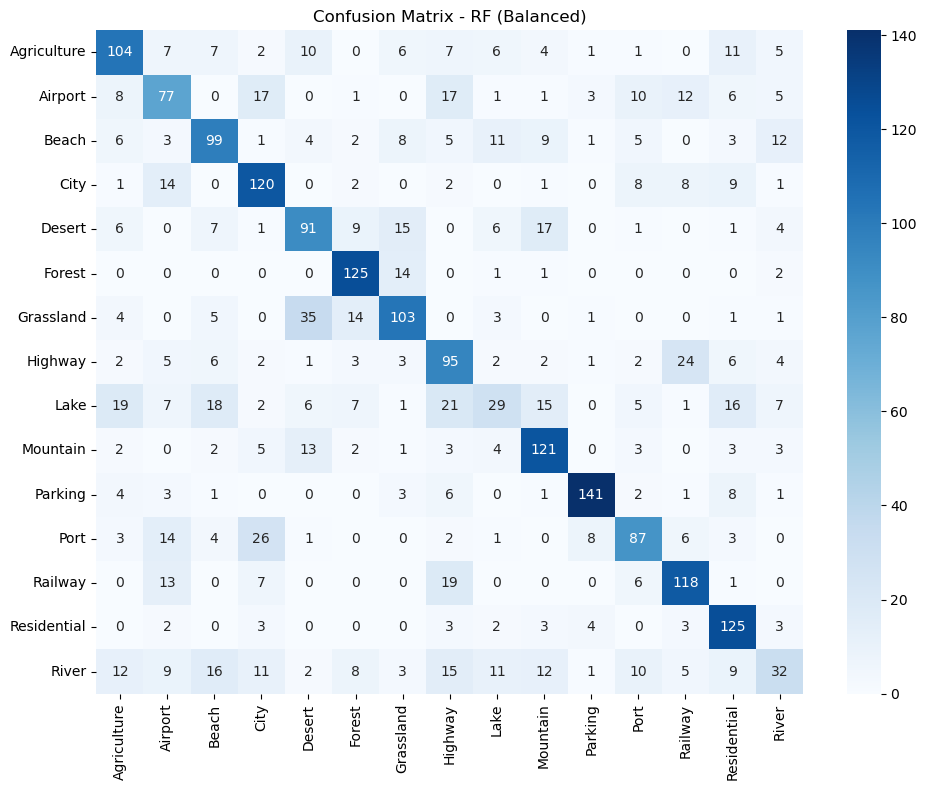

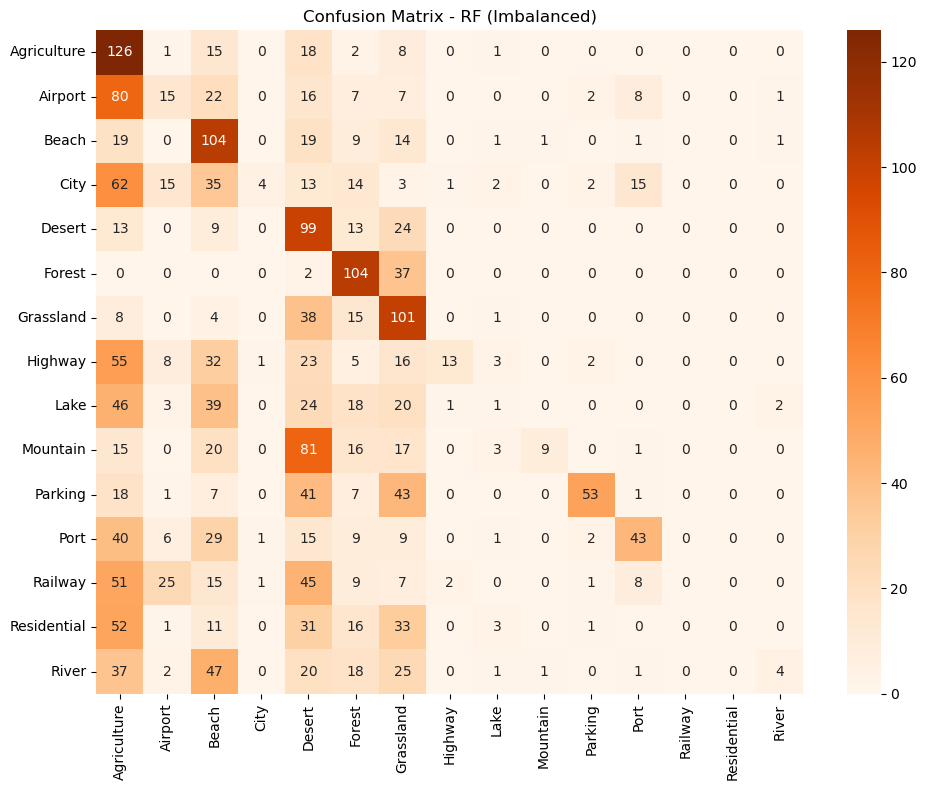

E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


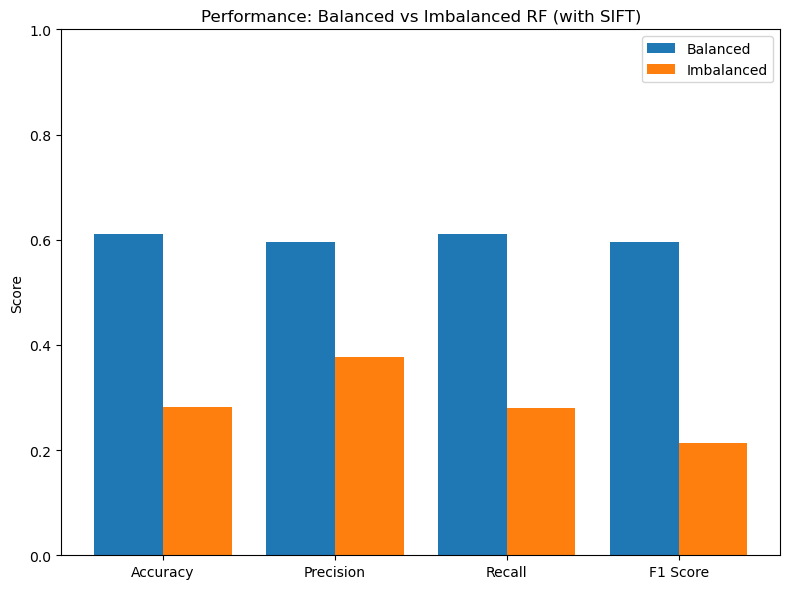

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import random

# ===================== Parameter Settings =====================
IMG_SIZE = (256, 256)
SEED = 42
NUM_CLUSTERS = 200
MAX_DESCRIPTORS_PER_IMAGE = 100

DATASET_DIR = r"D:\\quark download\\9517 Week1 home work\\project\\Aerial_Landscapes"
INDEX_DIR = r"D:\\quark download\\9517 Week1 home work\\project\\preprocess"

# ===================== Load and Preprocess =====================
class_names = sorted(os.listdir(DATASET_DIR))
image_paths, labels = [], []
for label_index, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_DIR, class_name)
    for file_name in sorted(os.listdir(class_dir)):
        if file_name.lower().endswith('.jpg'):
            image_paths.append(os.path.join(class_dir, file_name))
            labels.append(label_index)
labels = np.array(labels)

train_indices = np.load(os.path.join(INDEX_DIR, 'train_indices.npy'))
val_indices = np.load(os.path.join(INDEX_DIR, 'val_indices.npy'))

def load_images_by_indices(indices):
    X, y = [], []
    for i in indices:
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        X.append(img)
        y.append(labels[i])
    return np.array(X), np.array(y)

X_train_raw, y_train = load_images_by_indices(train_indices)
X_test_raw, y_test = load_images_by_indices(val_indices)

# ===================== Feature Extraction (SIFT + BoW) =====================
sift = cv2.SIFT_create()

def extract_sift_descriptors(img):
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

def build_codebook(images):
    all_descriptors = []
    for img in images:
        des = extract_sift_descriptors(img)
        if des is not None:
            if des.shape[0] > MAX_DESCRIPTORS_PER_IMAGE:
                des = des[np.random.choice(des.shape[0], MAX_DESCRIPTORS_PER_IMAGE, replace=False)]
            all_descriptors.append(des)
    all_descriptors = np.vstack(all_descriptors)
    kmeans = MiniBatchKMeans(n_clusters=NUM_CLUSTERS, random_state=SEED)
    kmeans.fit(all_descriptors)
    return kmeans

kmeans = build_codebook(X_train_raw)

def compute_bow_histogram(descriptors, kmeans):
    if descriptors is None or descriptors.shape[0] == 0:
        return np.zeros(NUM_CLUSTERS)
    words = kmeans.predict(descriptors)
    hist, _ = np.histogram(words, bins=np.arange(NUM_CLUSTERS + 1))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_sift_features(images):
    return np.array([compute_bow_histogram(extract_sift_descriptors(img), kmeans) for img in images])

X_train_features = extract_sift_features(X_train_raw)
X_test_features = extract_sift_features(X_test_raw)

scaler = StandardScaler()
X_train_features_norm = scaler.fit_transform(X_train_features)
X_test_features_norm = scaler.transform(X_test_features)

# ===================== Balanced RF Training =====================
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=SEED, class_weight='balanced')
rf_clf.fit(X_train_features_norm, y_train)
y_pred_rf = rf_clf.predict(X_test_features_norm)
print("Classification Report (Balanced):\n", classification_report(y_test, y_pred_rf, target_names=class_names))

# ===================== Data Augmentation =====================
def augment_image(img):
    augments = []
    augments.append(np.fliplr(img))
    augments.append(np.flipud(img))
    noisy = np.clip(img + np.random.normal(0, 0.03, img.shape), 0, 1)
    augments.append(noisy)
    return augments

# ===================== Imbalanced Dataset + Augmentation =====================
def create_imbalanced_dataset_with_aug(X, y, min_count=50):
    unique_classes = np.unique(y)
    new_X, new_y = [], []
    original_count = np.sum(y == unique_classes[0])
    for i, cls in enumerate(sorted(unique_classes)):
        desired = int(round(original_count - i * ((original_count - min_count) / (len(unique_classes) - 1))))
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        selected = cls_indices[:desired]
        for idx in selected:
            new_X.append(X[idx])
            new_y.append(y[idx])
        if desired < 80:
            for idx in selected:
                for aug in augment_image(X[idx]):
                    new_X.append(aug)
                    new_y.append(y[idx])
    return extract_sift_features(np.array(new_X)), np.array(new_y)

X_train_imbal, y_train_imbal = create_imbalanced_dataset_with_aug(X_train_raw, y_train)

# ===================== Imbalanced RF Training =====================
rf_clf_imbal = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=SEED, class_weight='balanced')
rf_clf_imbal.fit(X_train_imbal, y_train_imbal)
y_pred_rf_imbal = rf_clf_imbal.predict(X_test_features_norm)
print("Classification Report (Imbalanced):\n", classification_report(y_test, y_pred_rf_imbal, target_names=class_names))

# ===================== Confusion Matrices =====================
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - RF (Balanced)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_imbal), annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - RF (Imbalanced)")
plt.tight_layout()
plt.show()

# ===================== Performance Comparison =====================
metrics = [
    ("Accuracy", accuracy_score),
    ("Precision", lambda y1, y2: precision_score(y1, y2, average='macro')),
    ("Recall", lambda y1, y2: recall_score(y1, y2, average='macro')),
    ("F1 Score", lambda y1, y2: f1_score(y1, y2, average='macro')),
]

balanced_scores = [metric(y_test, y_pred_rf) for _, metric in metrics]
imbalanced_scores = [metric(y_test, y_pred_rf_imbal) for _, metric in metrics]

x = np.arange(len(metrics))
plt.figure(figsize=(8, 6))
plt.bar(x - 0.2, balanced_scores, 0.4, label='Balanced')
plt.bar(x + 0.2, imbalanced_scores, 0.4, label='Imbalanced')
plt.xticks(x, [m[0] for m in metrics])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Performance: Balanced vs Imbalanced RF (with SIFT)")
plt.legend()
plt.tight_layout()
plt.show()